In [1]:
import math
import json
import xarray as xr
import numpy as np
import geopandas as gpd
import pandas as pd
import dask.array as da

from xcube.core.geom import rasterize_features
from xcube.core.geom import mask_dataset_by_geometry

---

### Example: `rasterize_features()`

<AxesSubplot:>

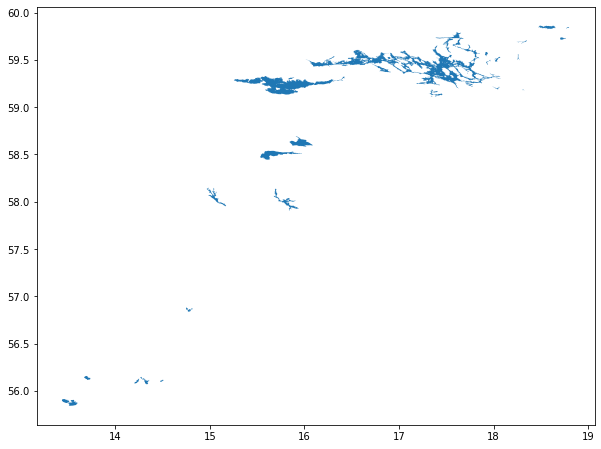

In [2]:
with open('../../serve/demo/places/Sweden-Lakes.geojson') as fp:
    features = json.load(fp)
features

features = gpd.GeoDataFrame.from_features(features)
features.plot(figsize=(10, 10))

In [3]:
x_min = 15
x_max = 19
y_min = 59
y_max = 60

width = 10000
tile_size = 2500

spatial_res = (x_max - x_min) / width
height = math.ceil((y_max - y_min) / spatial_res)

d = spatial_res / 2
lon = xr.DataArray(np.linspace(x_min + d, x_max - d, width), dims="lon")
lat = xr.DataArray(np.linspace(y_min + d, y_max - d, height), dims="lat")
lat = lat[::-1]  # Let y-axis have image orientation. Results will be same if commented out.
dataset = xr.Dataset(coords=dict(lon=lon, lat=lat))
dataset

<xarray.Dataset>
Dimensions:  (lon: 10000, lat: 2500)
Coordinates:
  * lon      (lon) float64 15.0 15.0 15.0 15.0 15.0 ... 19.0 19.0 19.0 19.0 19.0
  * lat      (lat) float64 60.0 60.0 60.0 60.0 60.0 ... 59.0 59.0 59.0 59.0 59.0
Data variables:
    *empty*

In [4]:
rasterized_features = rasterize_features(dataset, features, ['Medeldjup', 'Maxdjup'], tile_size=tile_size, all_touched=False) 
rasterized_features

<xarray.Dataset>
Dimensions:    (lon: 10000, lat: 2500)
Coordinates:
  * lon        (lon) float64 15.0 15.0 15.0 15.0 15.0 ... 19.0 19.0 19.0 19.0
  * lat        (lat) float64 60.0 60.0 60.0 60.0 60.0 ... 59.0 59.0 59.0 59.0
Data variables:
    Medeldjup  (lat, lon) float64 dask.array<chunksize=(2500, 2500), meta=np.ndarray>
    Maxdjup    (lat, lon) float64 dask.array<chunksize=(2500, 2500), meta=np.ndarray>

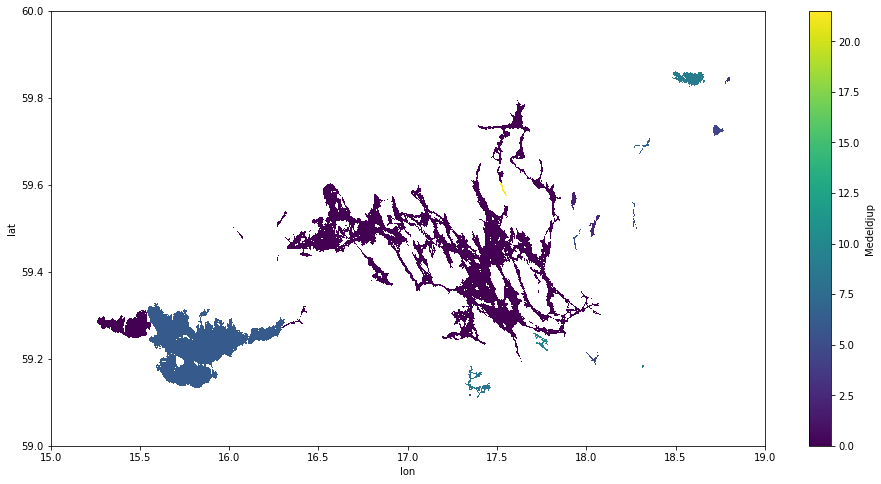

In [5]:
rasterized_features.Medeldjup.plot.imshow(figsize=(16, 8))

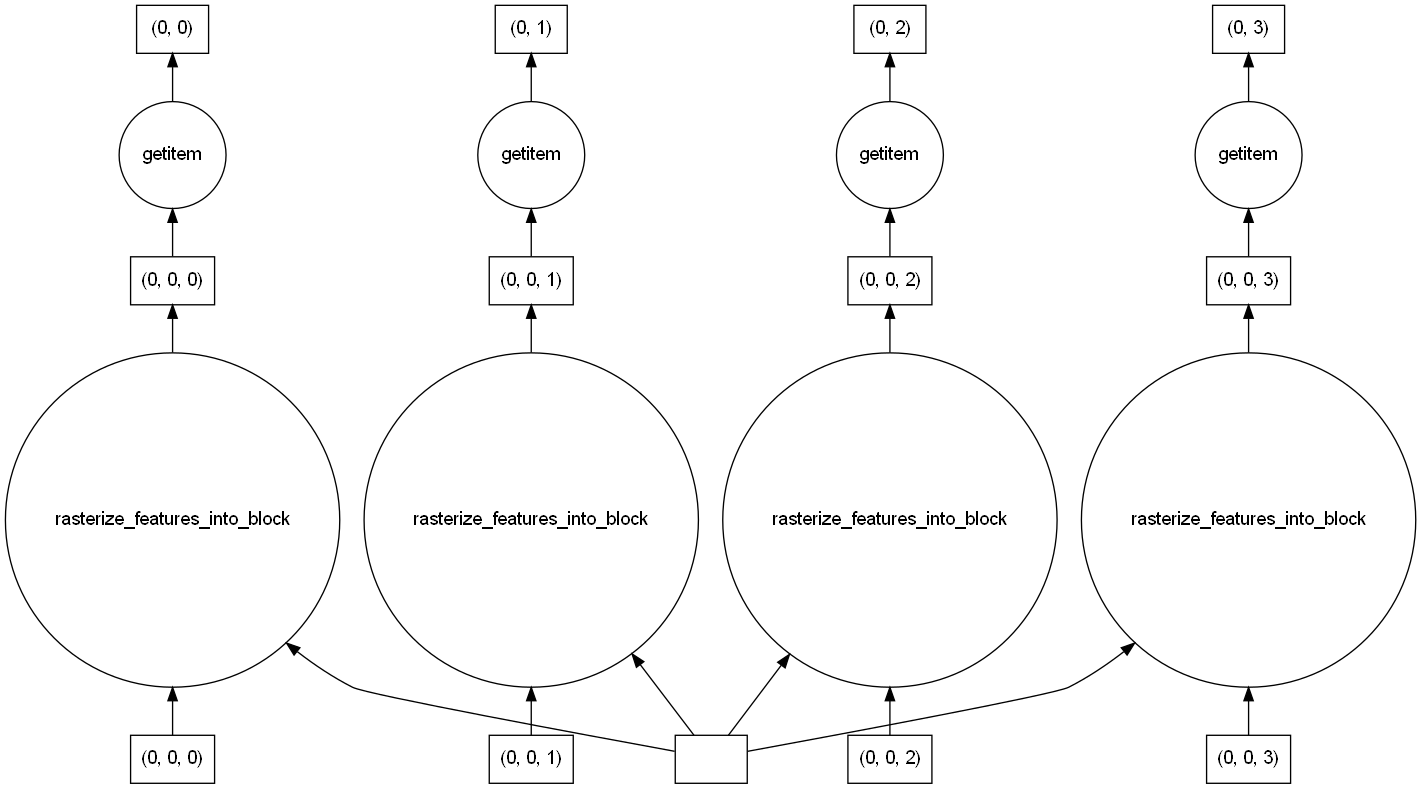

In [6]:
rasterized_features.Medeldjup.data.visualize()

---

### Example: `mask_dataset_by_geometry()`

In [7]:
periods = 3
time = pd.date_range(start='2022-04-25', periods=periods, freq='1D')
data_1 = da.full((height, width), 0.2, chunks=(tile_size, tile_size))
data_2 = da.full((height, width), 0.3, chunks=(tile_size, tile_size))
data_3 = da.full((height, width), 0.4, chunks=(tile_size, tile_size))
dataset["my_var"] = xr.DataArray(da.stack([data_1, data_2, data_3]), dims=("time", "lat", "lon"), coords=dict(time=time))
dataset

<xarray.Dataset>
Dimensions:  (lon: 10000, lat: 2500, time: 3)
Coordinates:
  * lon      (lon) float64 15.0 15.0 15.0 15.0 15.0 ... 19.0 19.0 19.0 19.0 19.0
  * lat      (lat) float64 60.0 60.0 60.0 60.0 60.0 ... 59.0 59.0 59.0 59.0 59.0
  * time     (time) datetime64[ns] 2022-04-25 2022-04-26 2022-04-27
Data variables:
    my_var   (time, lat, lon) float64 dask.array<chunksize=(1, 2500, 2500), meta=np.ndarray>

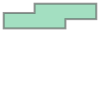

In [8]:
import shapely
b1 = shapely.geometry.box(15.5, 59.1, 17.5, 59.6)
b2 = shapely.geometry.box(16.5, 59.4, 18.5, 59.9)

geometry = b1.union(b2)
geometry

In [9]:
masked_dataset = mask_dataset_by_geometry(dataset, geometry, no_clip=True, save_geometry_mask='my_mask')

In [10]:
masked_dataset.my_var

<xarray.DataArray 'my_var' (time: 3, lat: 2500, lon: 10000)>
dask.array<where, shape=(3, 2500, 10000), dtype=float64, chunksize=(1, 2500, 2500), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 15.0 15.0 15.0 15.0 15.0 ... 19.0 19.0 19.0 19.0 19.0
  * lat      (lat) float64 60.0 60.0 60.0 60.0 60.0 ... 59.0 59.0 59.0 59.0 59.0
  * time     (time) datetime64[ns] 2022-04-25 2022-04-26 2022-04-27

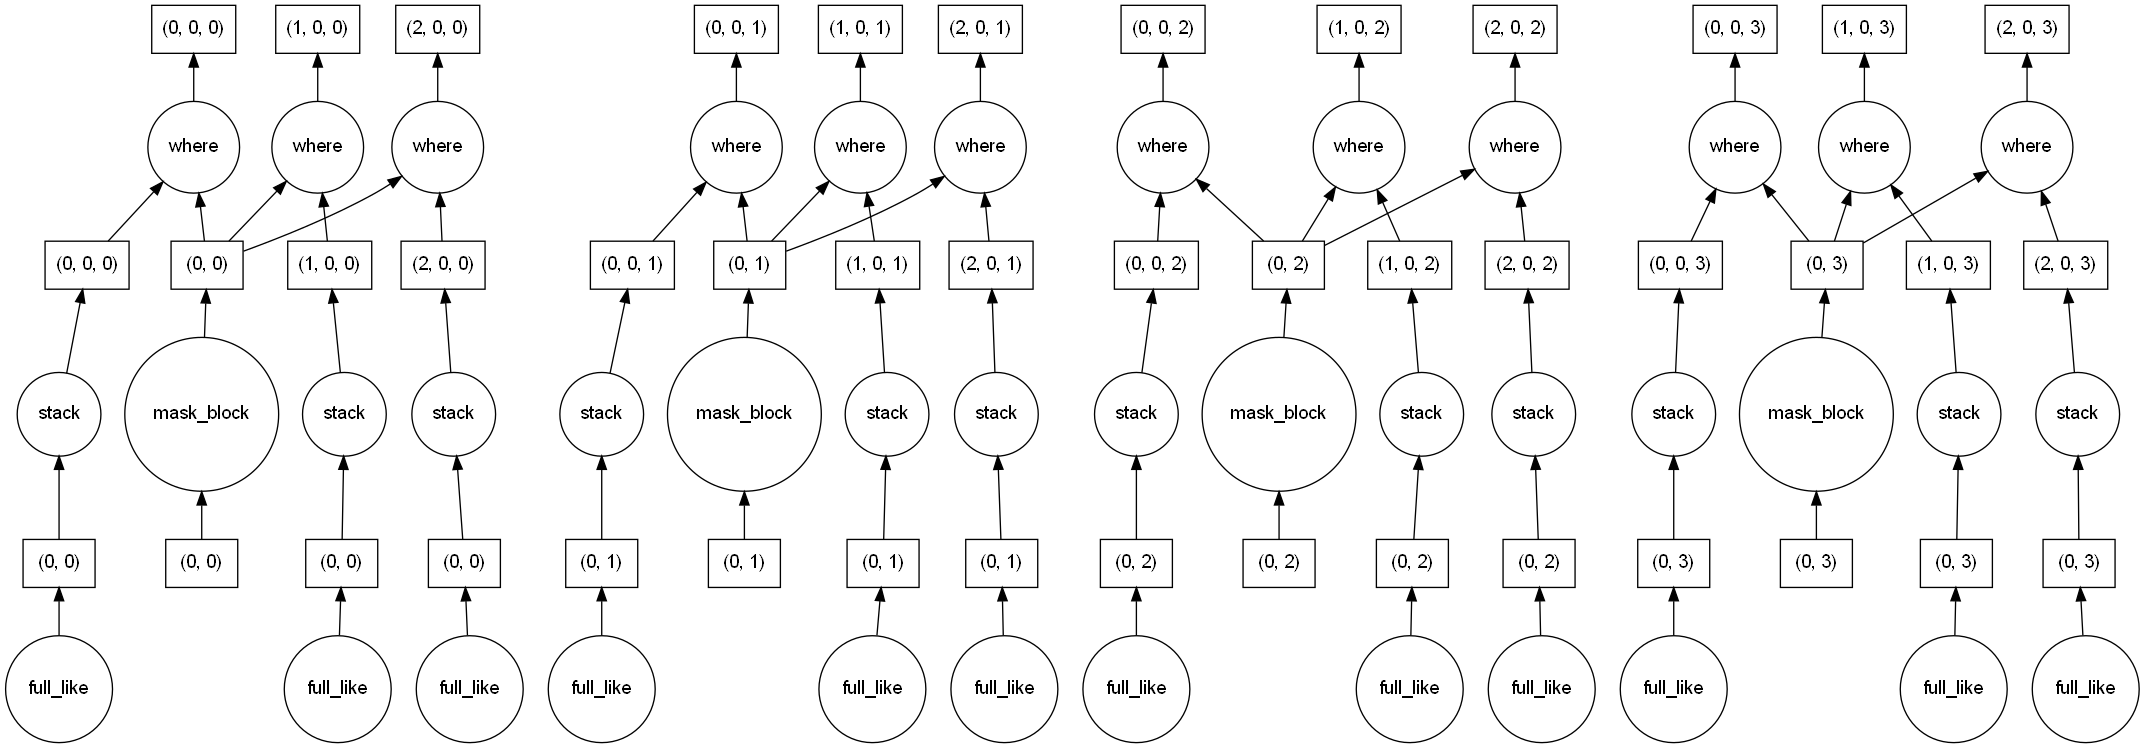

In [11]:
masked_dataset.my_var.data.visualize()

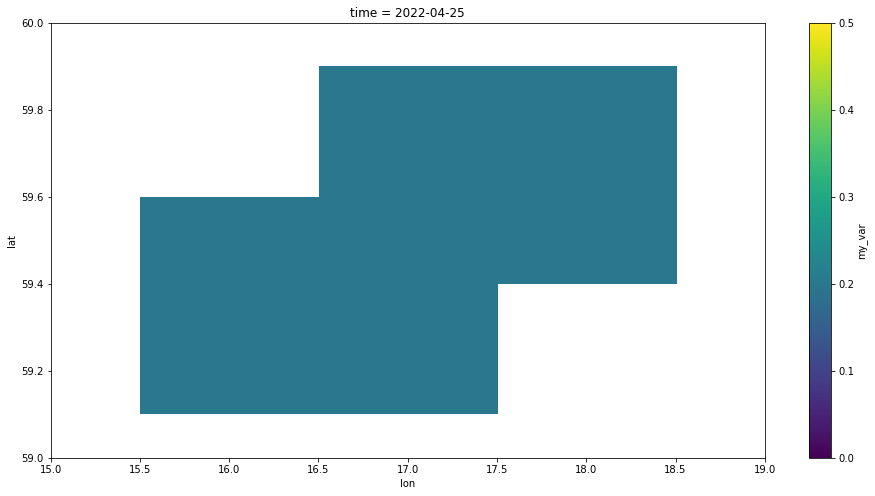

In [12]:
masked_dataset.my_var.isel(time=0).plot.imshow(figsize=(16, 8), vmin=0, vmax=0.5)

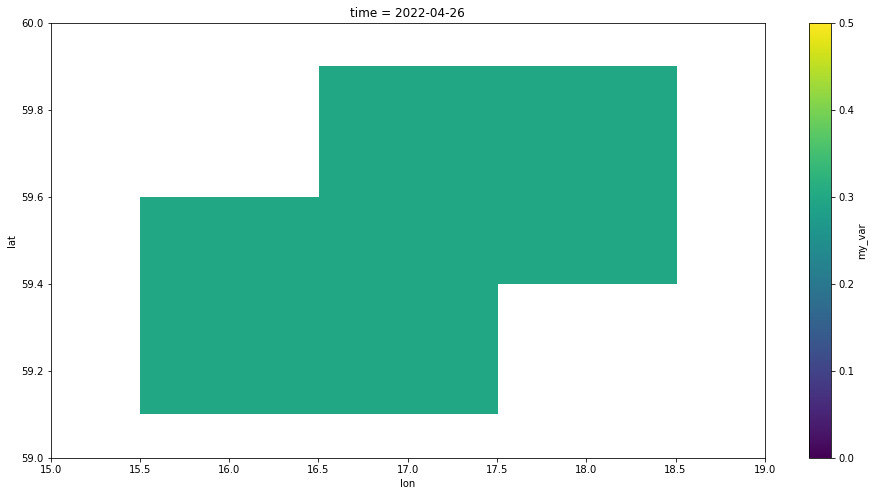

In [13]:
masked_dataset.my_var.isel(time=1).plot.imshow(figsize=(16, 8), vmin=0, vmax=0.5)

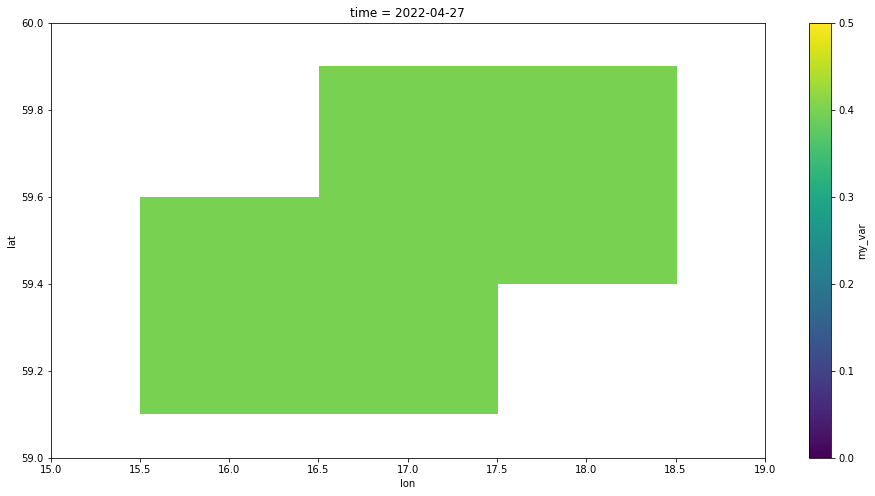

In [14]:
masked_dataset.my_var.isel(time=2).plot.imshow(figsize=(16, 8), vmin=0, vmax=0.5)

In [15]:
masked_dataset.my_mask

<xarray.DataArray 'my_mask' (lat: 2500, lon: 10000)>
dask.array<_mask_block, shape=(2500, 10000), dtype=bool, chunksize=(2500, 2500), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 15.0 15.0 15.0 15.0 15.0 ... 19.0 19.0 19.0 19.0 19.0
  * lat      (lat) float64 60.0 60.0 60.0 60.0 60.0 ... 59.0 59.0 59.0 59.0 59.0

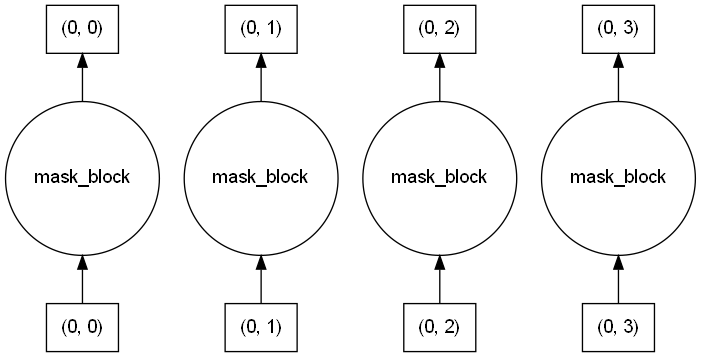

In [16]:
masked_dataset.my_mask.data.visualize()

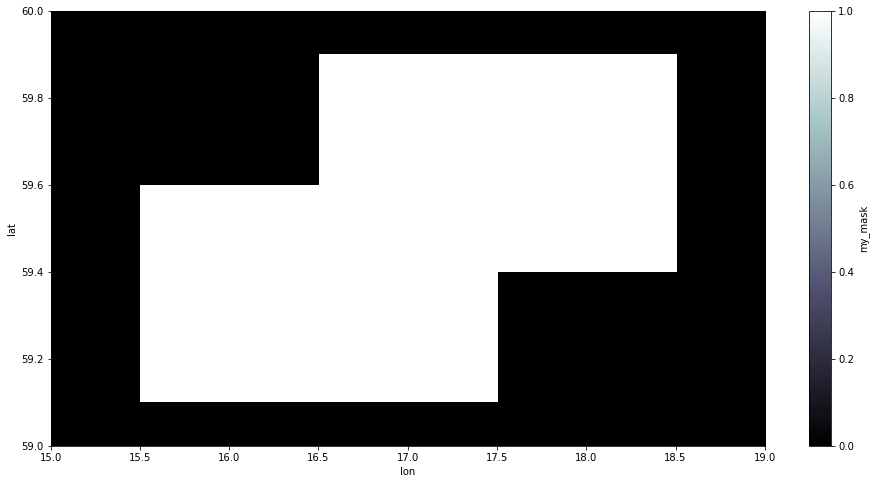

In [17]:
masked_dataset.my_mask.plot.imshow(figsize=(16, 8), cmap='bone')